In [ ]:
# Install requirements
%pip install -U setuptools pip
%pip install -r requirements.txt

In [ ]:
# Download MNIST data
!mkdir data
!curl "https://python-course.eu/data/mnist/mnist_train.csv" -o "./data/mnist_train.csv"
!curl "https://python-course.eu/data/mnist/mnist_test.csv" -o "./data/mnist_test.csv"

In [2]:
import csv
import numpy as np

# Read csv files

with open("data/mnist_train.csv") as f:
    reader = csv.reader(f)
    train = np.array(list(reader)).astype("int")

np.random.seed(0)
np.random.shuffle(train)

print(f"Train data shape: {train.shape}")


with open("data/mnist_test.csv") as f:
    reader = csv.reader(f)
    test = np.array(list(reader)).astype("int")

print(f"Test data shape: {test.shape}")

Train data shape: (60000, 785)
Test data shape: (10000, 785)


In [3]:
# Extract labels (1st column) (batch_size,)
train_labels = train[:, 0]
test_labels = test[:, 0]

# Extract features (2nd - last columns)
# Flattened 28x28 grayscale image into 1D array with 784 columns (batch_size, features)
train_features = train[:, 1:]
test_features = test[:, 1:]

# Normalize features (set all values to be between 0.0 - 1.0)
train_features = train_features / 255
test_features = test_features / 255

# One-hot encode labels (10 classes: 0 - 9) (batch_size, classes)
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

print(test_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
import importlib, os
import numpy as np
import nn, layer, loss, optimiser

# Set random seed (for reproducibility)
np.random.seed(0)

# Reload modules
for module in (nn, layer, loss, optimiser):
    importlib.reload(module)

# Folder to save models
folder = "models"

# No. of models
ensemble_size = 2
models = []

# Train models
for x in range(ensemble_size):
    # Fully connected neural network
    layers = [
        # Linear layer has no bias as batch norm layer has bias (beta)
        layer.LinearLayer(784, 200, biases=False),
        layer.BatchNorm1DLayer(200),
        layer.ReLULayer(),
        layer.DropoutLayer(0.1),
        layer.LinearLayer(200, 100, biases=False),
        layer.BatchNorm1DLayer(100),
        layer.ReLULayer(),
        layer.DropoutLayer(0.1),
        layer.LinearLayer(100, 10, biases=False),
        layer.SoftmaxLayer(),
    ]

    # Load model if file exists
    if os.path.exists(f"{folder}/model_{x}.pkl"):
        models.append(nn.load_model(f"{folder}/model_{x}.pkl"))
        print(f"Loaded model {x} from file")
    else:
        # Create new model
        models.append(
            nn.NeuralNetwork(
                layers,
                input_size=784,
                output_size=10,
            )
        )

        # Set weight normalisation parameters
        norm_kwargs = {"norm": "l2", "norm_alpha": 1e-5}

        # Create optimiser

        # Additional optional arguments for SGD's linear LR decay:
        #   lr_decay_iteration: Linearly decay LR until this interation
        #   lr_decay_min: Minimum LR to decay until
        # optim = optimiser.SGD(
        #     lr=0.1, lr_decay_iteration=10000, lr_decay_min=0.01, **norm_kwargs
        # )

        # optim = optimiser.SGD(lr=0.01, momentum=0.9, nesterov=True, **norm_kwargs)
        # optim = optimiser.AdaGrad(lr=0.01, epsilon=1e-8, **norm_kwargs)
        # optim = optimiser.RMSProp(
        #     lr=0.001, decay_rate=0.9, epsilon=1e-8, nesterov_momentum=0.9, **norm_kwargs
        # )
        optim = optimiser.Adam(
            lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, **norm_kwargs
        )

        # Create loss function
        loss_fn = loss.CrossEntropy()
        # loss_fn = loss.MSE()

        # Shuffle training data
        indexes = np.arange(train_features.shape[0])
        np.random.shuffle(indexes)
        shuffled_train_features = train_features[indexes]
        shuffled_train_labels = train_labels[indexes]

        # Training loop
        models[x].train(
            x=shuffled_train_features[2000:],  # Training data
            y=shuffled_train_labels[2000:],  # 80:20 split with validation data
            epochs=128,
            batch_size=1000,
            x_val=shuffled_train_features[:2000],  # Optional validation data
            y_val=shuffled_train_labels[:2000],  # Set to None to disable validation
            early_stopping=15,  # Threshold no. of rounds, set to -1 to disable
            loss_fn=loss_fn,
            optimiser=optim,
        )

        # Create folder
        if not os.path.exists(folder):
            os.mkdir(folder)

        # Save model
        models[x].save(f"{folder}/model_{x}.pkl")
        print(f"Saved model {x} to file")

Epoch: 49, Train Loss: 0.0242, Train Acc: 0.9940, Val Loss: 0.0694, Val Acc: 0.9770:  38%|███▊      | 49/128 [02:10<03:30,  2.66s/it]


Saved model 0 to file


Epoch: 53, Train Loss: 0.0217, Train Acc: 0.9950, Val Loss: 0.0629, Val Acc: 0.9820:  41%|████▏     | 53/128 [02:20<03:19,  2.66s/it]


Saved model 1 to file


In [44]:
# Ensemble scores
print(
    "Soft voting (mean): {:.2f}%".format(
        nn.score_ensemble_mean(models, test_features, test_labels) * 100
    )
)
print(
    "Hard voting (mode): {:.2f}%".format(
        nn.score_ensemble_mode(models, test_features, test_labels) * 100
    )
)

Soft voting (mean): 98.27%
Hard voting (mode): 97.88%


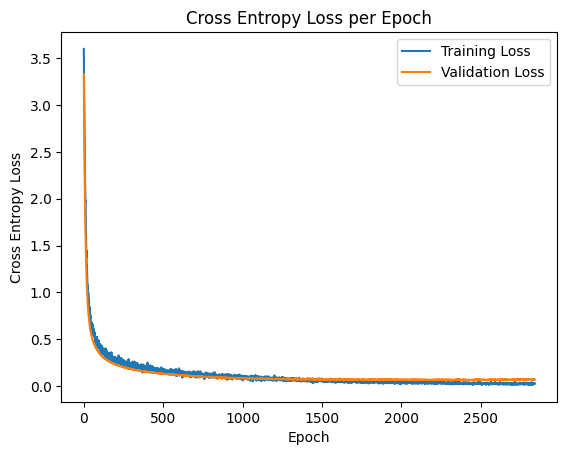

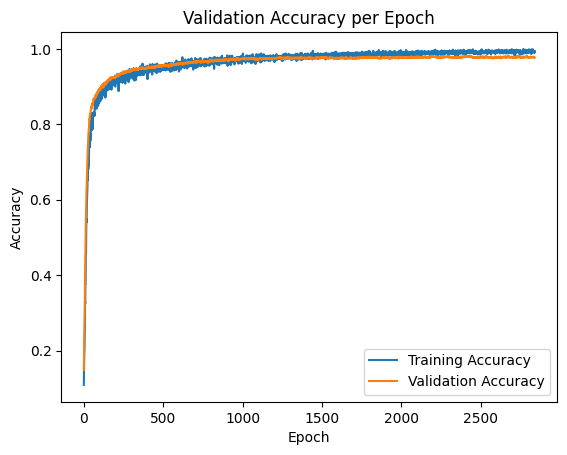

Predicted: 7
Actual: 7


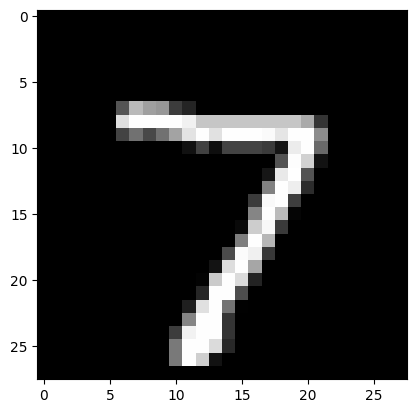

In [45]:
%matplotlib inline

# Single model loss and accuracy
models[0].plot_loss()
models[0].plot_acc()

# Test prediction from an index
models[0].test_pred(0, test_features, test_labels)